# Understanding neural_datasets

The purpose of this notebook is to do a "walkthrough" of one of the the brain score datasets, so we can better understand the analysis pipeline. How do we go from "model_identifier" and "benchmark_identifier" to a "brain score"?

In this notebook we'll trace the path for the "MajajHong2015public.IT-pls" benchmark.

# Where do we start? 

**What exactly was the MajajHong2015public.IT-pls experiment?**

You can read the paper that goes with this dataset here: https://www.jneurosci.org/content/35/39/13402, but for all vision experiments, the general experiment is "show animal images" while "recording neural responses". You might also have the animal performing a task (e.g., making a decision about each image), but often for neurophysiology experiments the task is "passive viewing" (stay awake and look at these images).

*So, to understand any visual neurophysiology experiment, you need to ask four sets of questions.*

**First, you should ask about the "goal" of the experiment (the driving question)**

What was the goal of the experiment? Usually this can be stated as a question that you can locate in the abstract. In this case, the authors goal was to figure out how to predict HUMAN object recognition accuracy based on MONKEY neural responses, in order to develop a theory of how neural responses are converted into behavioral responses. 

**Second, you should ask "how are they going to address this question?"**

"To address this question, they presented humans with an object recognition task. People viewed objects on random backgrounds and various positions, orientations, and poses, and the human had to identify the objects. They assumed the monkeys have similar object recognition abilities, but instead of doing object recognition with the monkeys (hard to teach them the 64 choices), the monkeys just viewed the same objects while having neural resposnes in V1, V4, and IT recorded.

**Third you should ask about the "stimuli" as well as the "task" and "trial" design**

*What were the actual stimuli?* To determine this, you need to dig into the methods. "High-quality images of single objects were generated using ray-tracing software. Each image was a 2D projection of a 3D model with a random background. Most backgrounds were uncorrelated with the objects, except for a few accidental correlations (e.g., a plane on a sky background). The database contained 5760 images of 64 objects across eight categories (e.g., animals, cars, faces), with eight exemplars per category. Six viewing parameters varied, including object identity, position, rotation, and size."


*What was the human task and trial design?* A total of 104 humans participated in 1 of 3 visual task sets: an 8-way classification of images of 8 different cars, an 8-way classification of images of 8 different faces, or an 8-way categorization of images of objects from 8 different basic-level categories. Each trial started with a central fixation point that lasted for 500 ms, after which an image appeared at the center of the screen for 100 ms. After a 300 ms delay, the observer was prompted to click one of eight “response” images that matched the identity or category of the stimulus image. To enforce the need for view tolerant “object” recognition (rather than image matching), each response image displayed a single object from a canonical view without background. The image presentation time was chosen based on results showing that core object recognition performance improves quickly over time such that accuracy for a 100 ms presentation time is within 92% of performance at 2 s (see Fig. S2 in Cadieu et al., 2014). Results were very similar, with slightly shorter (50 ms) or longer (200 ms) viewing duration.

*What was the animal task and trial design?* The monkey's task was to maintain fixation on a dot while 5-10 images were shown in sequence at the center of gaze, each for 100 ms with 100 ms gaps. Images subtended 8° of the visual field and were presented randomly, each repeated at least 28 times (typically ~50 times). Neural responses were recorded for 5760 images, using the same pool and presentation parameters as in human testing.

**Finally, you should ask about the details of the neural recording**

(I used ChatGPT to summarize the methods and it did a fairly nice job here...)

Two adult male rhesus monkeys were surgically implanted with head posts and trained using juice rewards to fixate on a central target. Neural activity was recorded from implanted microelectrode arrays placed in visual brain areas V4 and IT. Eye movements were monitored using video eye tracking, and all procedures followed ethical guidelines.

Neural activity was recorded continuously at 30 kHz using band-pass filtered signals. Multiunit activity (MUA) was defined as voltage threshold crossings, set during the beginning of each session. From 576 electrodes across both monkeys, 296 visually responsive sites were selected. Spike times were recorded at all sites, with neural responses grouped into V4 and IT populations. Population responses to 5760 images were summarized as matrices, recorded over multiple days (68 for Monkey 1 and 65 for Monkey 2).


# Run the brainscore analysis on alexnet

OK, so now we know what the experiment was, and that the neural data for MajajHong2015public.IT-pls will be neural responses to 5760 images matching objects and presentation parameters used in a human object recognition experiment.

The "brainscore" for this experiment will then be testing how well "model activations" predict/correspond with "monkey IT responses" to a set of imgaes.

Before we breakdown this brainscore, let's first run the official brainscore code for MajajHong2015.IT-pls, for which alexnet gets ascore .508 on the brainscore website. 

Running this here, the score we get is 0.50480012. We're going to take that as "close enough". The descrepancy could be do to differences in what data they make "public" versus what data they keep "private" (only accessible by the brainscore website platform). Notice below we are actually running "MajajHong2015public.IT-pls" (note the "public" in the benchmark name).

Note also that we get a noise ceiling of 0.81579938, which later we'll compute ourselves.

In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import os
import time
from PIL import Image
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from brainscore_vision import score

/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [3]:
from brainscore_vision.benchmarks.majajhong2015 import *
from brainscore_vision.benchmarks.majajhong2015.benchmark import load_assembly
from brainscore_vision import benchmark_registry

benchmark_registry

{'MajajHong2015.V4-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.DicarloMajajHong2015V4PLS()>,
 'MajajHong2015.IT-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.DicarloMajajHong2015ITPLS()>,
 'MajajHong2015public.V4-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.MajajHongV4PublicBenchmark()>,
 'MajajHong2015public.IT-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.MajajHongITPublicBenchmark()>,
 'MajajHong2015public.V4-temporal-pls': <function brainscore_vision.benchmarks.majajhong2015.<lambda>()>,
 'MajajHong2015public.IT-temporal-pls': <function brainscore_vision.benchmarks.majajhong2015.<lambda>()>}

In [3]:
start_time = time.time()
model_identifier = 'alexnet'
benchmark_identifier = f'MajajHong2015public.IT-pls'

similarity_score = score(model_identifier=model_identifier, benchmark_identifier=benchmark_identifier)
end_time = time.time()
dur_min = (end_time - start_time) / 60
print(f"Duration in min = {dur_min:3.2f}")
similarity_score

Defaulting to user installation because normal site-packages is not writeable


/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


cross-validation: 100%|██████████| 10/10 [05:33<00:00, 33.31s/it]

Duration in min = 5.93


<xarray.Score ()>
array(0.50480012)
Attributes:
    error:                 <xarray.Score ()>\narray(0.00269298)
    raw:                   <xarray.Score ()>\narray(0.57961964)\nAttributes:\...
    ceiling:               <xarray.DataArray ()>\narray(0.81579938)\nAttribut...
    model_identifier:      alexnet
    benchmark_identifier:  MajajHong2015public.IT-pls
    comment:               layers: {'IT': 'features.12'}

# Now What?

Our overall goal is to reproduce this result "step-by-step" using "as little of the brainscore code as possible", re-writing the analysis ourselves from scratch. We'll make many exceptions (e.g., using their "load_dataset" seems like a reasonable way to load the data, we don't need to re-write that ourselves).

To do so, we'll:
1) explore the neural dataset, make sure we understand the format of the stored brain data
2) visualize some of their stimuli / images
3) plot the neural response across sites to a few different images to get a "feel" for the dataset
4) compute the noise ceiling ourselves - this will require us to really understand the data format, exactly what neural responses we are trying to predict from the models, and how the noise ceiling calculation works
5) compute alexnet's "brainscore" ouselves - this will require us to really understand the "linking hypothesis" that they use to relate the model activations to neural activations


# 1. Explore the neural dataset

The data are stored in an "xarray" which is like a "numpy array" with metadata about the rows and columns, and "superpowers" for slicing/indexing subsets of the data.

In [4]:
import numpy as np
import pandas as pd

from brainscore_vision import benchmark_registry
from brainscore_vision import load_metric, Ceiling, load_ceiling, load_dataset
from brainscore_vision.metrics.distribution_similarity import NeuronalPropertyCeiling
from brainscore_core.metrics import Metric, Score
from brainscore_vision.metric_helpers import Defaults as XarrayDefaults


**Let's load the dataset and visualize it's contents**

It looks to me like there are 256 brain recording sites, and 148480 image presentations. 

There are also "multiindex" coordinates that allow you to slice along the *neuroid* dimension or the *presentation* dimension. There's a *time_bin* coordinate as well, but it looks like only one time bin in the whole dataset (70-170ms), so we'll ignore that for now.

Finally, there are "attributes" which are additional metadata/information about the dataset, but it isn't tied to the rows/columns of xarray.

In [5]:
ASSEMBLY_NAME = 'MajajHong2015.public'
assembly = load_dataset(ASSEMBLY_NAME)
assembly

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (neuroid: 256,
                                                                presentation: 148480,
                                                                time_bin: 1)>
dask.array<open_dataset-027f6ff4c498b94c72f000f20552e29bdicarlo.MajajHong2015.public, shape=(256, 148480, 1), dtype=float32, chunksize=(256, 148480, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 18 18 18 18 18 ... 16 16 16 17 17 17
  - stimulus         (presentation) int64 0 426 427 428 429 ... 2569 2566 0 1 2
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 418 419 420 421 ... 3197 641 642 643
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 ... 1.246 1.296 0.9114
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... 0.02724 -10.4
  - tz               (presentation) float64 0.0 0.0 0.0 ... -0.269 -0.599 0.211
  - category_name    (presentation) object 'Cars' 'Faces' ... 'Fruits' 'Fruits'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  - ty               (presentation) float64 0.0 0.0 0.0 ... -0.191 -0.213 0.277
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - object_name      (presentation) object 'car_astra' 'face0' ... 'apple'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 -0.0 -0.0 ... 0.02724 -10.4
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - rxz              (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  * time_bin         (time_bin) MultiIndex
  - time_bin_start   (time_bin) int64 70
  - time_bin_end     (time_bin) int64 170
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

**we can access the full dataset like so**

Note that brainscore has these as "dask" arrays. I'm not as familiar with those, but for now, for us, it means sometimes you cannot treat this exactly like a regular numpy array. Somethings will work, some things need an extra step (see below)

In [6]:
assembly.data.shape

(256, 148480, 1)

**ok, but what are the VALUES stored in this array?** That's a great question. I have no idea, and I can't figure it out. I think it's a "change in spiking rate relative to baseline"? Some of the values are negative, some are positive. maybe this is z-scored firing rate?

In [7]:
assembly.min().compute(), assembly.max().compute()

(<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' ()>
 array(-5.8631735, dtype=float32),
 <xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' ()>
 array(26.572945, dtype=float32))

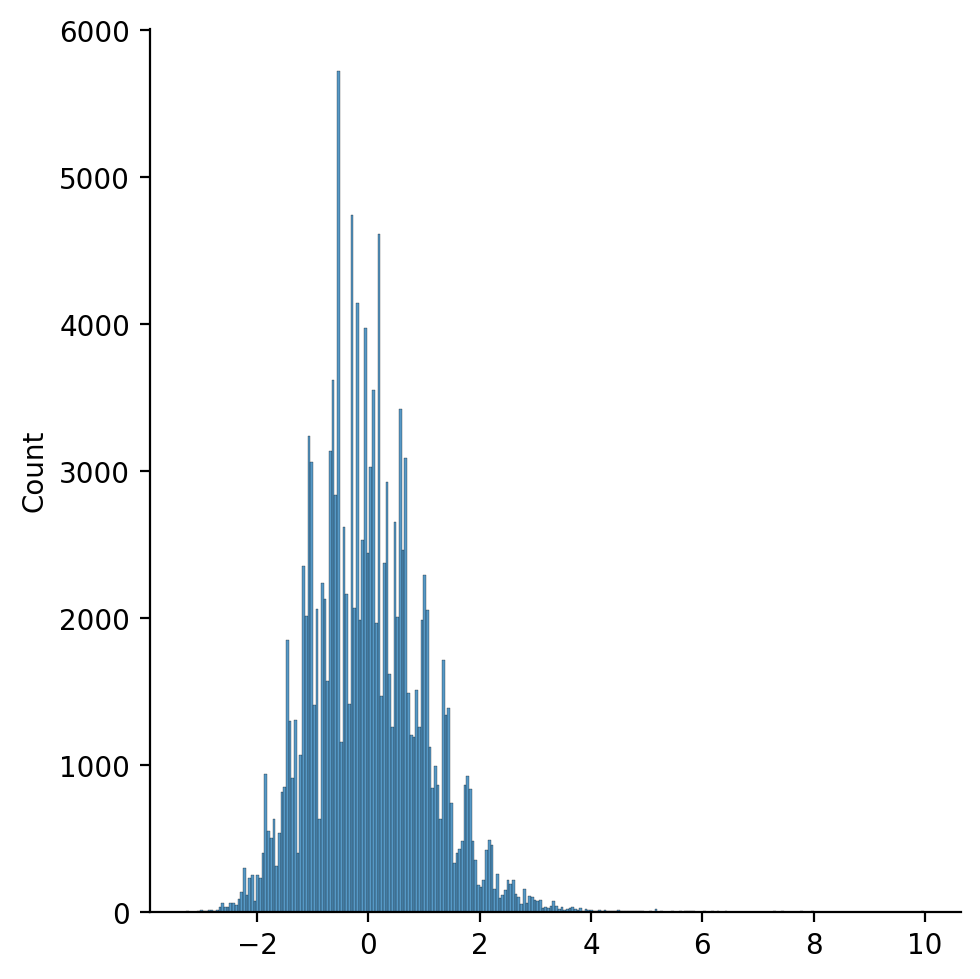

In [8]:
import seaborn as sns

data = assembly.data[0,:].compute().flatten()
sns.displot(data)

**notice than an xarray has "coordinates"**

These coordinates are essentially "metadata" about a slice of the data. e.g., notice that there are 256 values for the "neuroid" coordinates. Notice also that "neuroid" is a multiindex" which means itself is composed of multiple dimensions (neuroid_id, hemisphere, subregion)

In [9]:
print("number of neuroid values:", assembly.neuroid.shape)
assembly.neuroid[0]

number of neuroid values: (256,)


<xarray.NeuronRecordingAssembly 'neuroid' ()>
array(('Chabo_L_M_5_9', 'M', 9, 'L', 'cIT', 'Chabo', 0.2, 1.8, 'IT', 5),
      dtype=object)
Coordinates:
    neuroid  object ('Chabo_L_M_5_9', 'M', 9, 'L', 'cIT', 'Chabo', 0.2, 1.8, ...

In [10]:
print("number of presentation values:", assembly.presentation.shape)
assembly.presentation[0]

number of presentation values: (148480,)


<xarray.NeuronRecordingAssembly 'presentation' ()>
array(('8a72e2bfdb8c267b57232bf96f069374d5b21832', 0, 0, '8a72e2bfdb8c267b57232bf96f069374d5b21832', 1, 'ecd40f3f6d7a4d6d88134d648884e0b9b364efc9', 1.0, 'astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty+00.000_s+01.000_ecd40f3f6d7a4d6d88134d648884e0b9b364efc9_256x256.png', 'astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty+00.000_s+01.000_ecd40f3f6d7a4d6d88134d648884e0b9b364efc9_256x256.png', -0.0, 0.0, 'Cars', 0.0, 0.0, -0.0, 'car_astra', 0, 256.0, 90.0, -0.0, 0.0),
      dtype=object)
Coordinates:
    presentation  object ('8a72e2bfdb8c267b57232bf96f069374d5b21832', 0, 0, '...

# 2. visualize some of their stimuli / images

Next it would be nice to display some of their test images, and also plot neural responses across sites to a couple of those images. 

**let's access the stimulus set**

The stimulus set information is stored as an attribute called "stimulus_set" and it's a dataframe with information about each of the 3200 unique stimulu presented to the animals in this public dataset.

In [11]:
stimulus_set = assembly.attrs['stimulus_set']
stimulus_set

,id,background_id,s,image_id,image_file_name,filename,rxy,tz,category_name,rxz_semantic,ty,ryz,object_name,variation,size,rxy_semantic,ryz_semantic,rxz,stimulus_id
0,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,8a72e2bfdb8c267b57232bf96f069374d5b21832,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,0.000,Cars,0.000000,0.000,-0.000000,car_astra,0,256.0,90.000000,-0.000000,0.000000,8a72e2bfdb8c267b57232bf96f069374d5b21832
1,2,006d66c207c6417574f62f0560c6b2b40a9ec5a1,1.000000,27f69468c9d6019ed0d22b9583c94c5b58198c1c,_12_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty...,_12_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty...,-0.000000,0.000,Tables,0.000000,0.000,-0.000000,table3,0,256.0,-0.000000,-0.000000,0.000000,27f69468c9d6019ed0d22b9583c94c5b58198c1c
2,3,3b3c1d65865028d0fad0b0bf8f305098db717e7f,1.000000,6af1cbb28aacea6c582faa07e92d8325fa7a29d7,face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,0.000,Faces,0.000000,0.000,-0.000000,face2,0,256.0,-0.000000,-0.000000,0.000000,6af1cbb28aacea6c582faa07e92d8325fa7a29d7
3,4,687ade2f9ee4d52af9705865395471a24ba38d5f,1.000000,d0f7a45b377d4920c3466ec7a20dce9437a150d6,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,-0.000000,0.000,Fruits,0.000000,0.000,-0.000000,walnut,0,256.0,-0.000000,-0.000000,0.000000,d0f7a45b377d4920c3466ec7a20dce9437a150d6
4,5,724e5703cc42aa2c3ff135e3508038a90e4ebcb3,1.000000,d4c3b4d4aefd29fd168a2c3c9a9962d99653a715,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,-0.000000,0.000,Fruits,0.000000,0.000,-0.000000,walnut,0,256.0,-0.000000,-0.000000,0.000000,d4c3b4d4aefd29fd168a2c3c9a9962d99653a715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,3196,70222407751181c4b7723cb09dbda63e7f9c7333,1.286154,caf392d996023d49d9be520da255f865a014f646,_19_flyingBoat_rx+27.024_ry+104.520_rz+100.874...,_19_flyingBoat_rx+27.024_ry+104.520_rz+100.874...,27.783925,0.280,Planes,-12.905496,0.096,17.585453,airplane2,3,256.0,117.783925,17.585453,-12.905496,caf392d996023d49d9be520da255f865a014f646
3196,3197,f144e3aabccefb4228b8257506a2aa26ba5b4a6d,1.234000,4fefbea44756719f5cded1539b1c092e352beab0,Beetle_rx-06.302_ry-39.833_rz+22.244_tx-00.197...,Beetle_rx-06.302_ry-39.833_rz+22.244_tx-00.197...,-39.833000,-0.042,Cars,-6.302000,-0.197,22.244000,car_beetle,3,256.0,50.167000,22.244000,-6.302000,4fefbea44756719f5cded1539b1c092e352beab0
3197,3198,9b87c8be1440ce9626bcfe656700ff3ac8f909fe,0.895714,b1dbd1fc08edf4dc0814c5578e2c5544ea4d255d,_001_rx-13.140_ry-26.381_rz+09.423_tx+00.218_t...,_001_rx-13.140_ry-26.381_rz+09.423_tx+00.218_t...,-26.381000,0.000,Chairs,-13.140000,0.218,9.423000,chair0,3,256.0,-26.381000,9.423000,-13.140000,b1dbd1fc08edf4dc0814c5578e2c5544ea4d255d
3198,3199,c3edce2a8fce8c088605bd27fe1f2e7958939f54,1.187143,7c5174365cf0ed5a3319250d5913bcd8217f1454,_004_rx+11.926_ry-44.019_rz+38.652_tx-00.103_t...,_004_rx+11.926_ry-44.019_rz+38.652_tx-00.103_t...,-44.019000,0.521,Chairs,11.926000,-0.103,38.652000,chair1,3,256.0,-44.019000,38.652000,11.926000,7c5174365cf0ed5a3319250d5913bcd8217f1454


id                                                                 1
background_id               ecd40f3f6d7a4d6d88134d648884e0b9b364efc9
s                                                                1.0
image_id                    8a72e2bfdb8c267b57232bf96f069374d5b21832
image_file_name    astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
filename           astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
rxy                                                             -0.0
tz                                                               0.0
category_name                                                   Cars
rxz_semantic                                                     0.0
ty                                                               0.0
ryz                                                             -0.0
object_name                                                car_astra
variation                                                          0
size                              

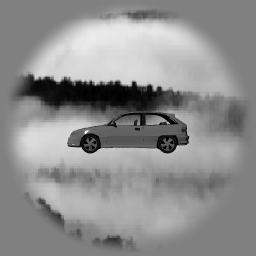

In [12]:
img1_info = stimulus_set.iloc[0]
print(img1_info)
local_path = stimulus_set.get_stimulus(img1_info.stimulus_id)
img1 = Image.open(local_path)
img1

id                                                                 3
background_id               3b3c1d65865028d0fad0b0bf8f305098db717e7f
s                                                                1.0
image_id                    6af1cbb28aacea6c582faa07e92d8325fa7a29d7
image_file_name    face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...
filename           face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...
rxy                                                             -0.0
tz                                                               0.0
category_name                                                  Faces
rxz_semantic                                                     0.0
ty                                                               0.0
ryz                                                             -0.0
object_name                                                    face2
variation                                                          0
size                              

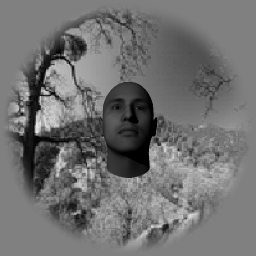

In [13]:
img2_info = stimulus_set.iloc[2]
print(img2_info)
local_path = stimulus_set.get_stimulus(img2_info.stimulus_id)
img2 = Image.open(local_path)
img2

# 3. plot the neural response across sites to a few different images to get a "feel" for the dataset

## Let's plot activations for this var versus this face

In [14]:
stimulus_set = assembly.attrs['stimulus_set']
stimulus_set

,id,background_id,s,image_id,image_file_name,filename,rxy,tz,category_name,rxz_semantic,ty,ryz,object_name,variation,size,rxy_semantic,ryz_semantic,rxz,stimulus_id
0,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,8a72e2bfdb8c267b57232bf96f069374d5b21832,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,0.000,Cars,0.000000,0.000,-0.000000,car_astra,0,256.0,90.000000,-0.000000,0.000000,8a72e2bfdb8c267b57232bf96f069374d5b21832
1,2,006d66c207c6417574f62f0560c6b2b40a9ec5a1,1.000000,27f69468c9d6019ed0d22b9583c94c5b58198c1c,_12_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty...,_12_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty...,-0.000000,0.000,Tables,0.000000,0.000,-0.000000,table3,0,256.0,-0.000000,-0.000000,0.000000,27f69468c9d6019ed0d22b9583c94c5b58198c1c
2,3,3b3c1d65865028d0fad0b0bf8f305098db717e7f,1.000000,6af1cbb28aacea6c582faa07e92d8325fa7a29d7,face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,0.000,Faces,0.000000,0.000,-0.000000,face2,0,256.0,-0.000000,-0.000000,0.000000,6af1cbb28aacea6c582faa07e92d8325fa7a29d7
3,4,687ade2f9ee4d52af9705865395471a24ba38d5f,1.000000,d0f7a45b377d4920c3466ec7a20dce9437a150d6,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,-0.000000,0.000,Fruits,0.000000,0.000,-0.000000,walnut,0,256.0,-0.000000,-0.000000,0.000000,d0f7a45b377d4920c3466ec7a20dce9437a150d6
4,5,724e5703cc42aa2c3ff135e3508038a90e4ebcb3,1.000000,d4c3b4d4aefd29fd168a2c3c9a9962d99653a715,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,walnut_obj_rx-90.000_ry+00.000_rz+00.000_tx+00...,-0.000000,0.000,Fruits,0.000000,0.000,-0.000000,walnut,0,256.0,-0.000000,-0.000000,0.000000,d4c3b4d4aefd29fd168a2c3c9a9962d99653a715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,3196,70222407751181c4b7723cb09dbda63e7f9c7333,1.286154,caf392d996023d49d9be520da255f865a014f646,_19_flyingBoat_rx+27.024_ry+104.520_rz+100.874...,_19_flyingBoat_rx+27.024_ry+104.520_rz+100.874...,27.783925,0.280,Planes,-12.905496,0.096,17.585453,airplane2,3,256.0,117.783925,17.585453,-12.905496,caf392d996023d49d9be520da255f865a014f646
3196,3197,f144e3aabccefb4228b8257506a2aa26ba5b4a6d,1.234000,4fefbea44756719f5cded1539b1c092e352beab0,Beetle_rx-06.302_ry-39.833_rz+22.244_tx-00.197...,Beetle_rx-06.302_ry-39.833_rz+22.244_tx-00.197...,-39.833000,-0.042,Cars,-6.302000,-0.197,22.244000,car_beetle,3,256.0,50.167000,22.244000,-6.302000,4fefbea44756719f5cded1539b1c092e352beab0
3197,3198,9b87c8be1440ce9626bcfe656700ff3ac8f909fe,0.895714,b1dbd1fc08edf4dc0814c5578e2c5544ea4d255d,_001_rx-13.140_ry-26.381_rz+09.423_tx+00.218_t...,_001_rx-13.140_ry-26.381_rz+09.423_tx+00.218_t...,-26.381000,0.000,Chairs,-13.140000,0.218,9.423000,chair0,3,256.0,-26.381000,9.423000,-13.140000,b1dbd1fc08edf4dc0814c5578e2c5544ea4d255d
3198,3199,c3edce2a8fce8c088605bd27fe1f2e7958939f54,1.187143,7c5174365cf0ed5a3319250d5913bcd8217f1454,_004_rx+11.926_ry-44.019_rz+38.652_tx-00.103_t...,_004_rx+11.926_ry-44.019_rz+38.652_tx-00.103_t...,-44.019000,0.521,Chairs,11.926000,-0.103,38.652000,chair1,3,256.0,-44.019000,38.652000,11.926000,7c5174365cf0ed5a3319250d5913bcd8217f1454


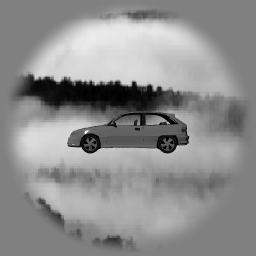

In [15]:
img1_info = stimulus_set.iloc[0]
local_path = stimulus_set.get_stimulus(img1_info.stimulus_id)
img1 = Image.open(local_path)
img1

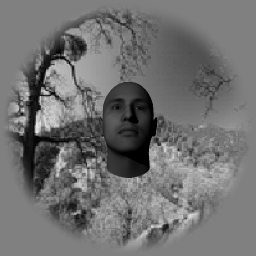

In [16]:
img2_info = stimulus_set.iloc[2]
local_path = stimulus_set.get_stimulus(img2_info.stimulus_id)
img2 = Image.open(local_path)
img2

**How do we get neural responses to one of these images?**

In [17]:
img1_info

id                                                                 1
background_id               ecd40f3f6d7a4d6d88134d648884e0b9b364efc9
s                                                                1.0
image_id                    8a72e2bfdb8c267b57232bf96f069374d5b21832
image_file_name    astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
filename           astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
rxy                                                             -0.0
tz                                                               0.0
category_name                                                   Cars
rxz_semantic                                                     0.0
ty                                                               0.0
ryz                                                             -0.0
object_name                                                car_astra
variation                                                          0
size                              

In [18]:
# Assuming `assembly` is your xarray DataArray or Dataset
stimulus_id = img1_info.stimulus_id

# Use `isel` to select all neural data corresponding to the specific stimulus ID
neural_data_for_stimulus1 = assembly.sel(presentation=assembly['stimulus_id'] == stimulus_id)
neural_data_for_stimulus1

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (neuroid: 256,
                                                                presentation: 28,
                                                                time_bin: 1)>
dask.array<getitem, shape=(256, 28, 1), dtype=float32, chunksize=(256, 28, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 19 18 20 15 17 ... 12 11 13 8 10 9
  - stimulus         (presentation) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - tz               (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - category_name    (presentation) object 'Cars' 'Cars' ... 'Cars' 'Cars'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - ty               (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - object_name      (presentation) object 'car_astra' ... 'car_astra'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 90.0 90.0 ... 90.0 90.0 90.0
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - rxz              (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * time_bin         (time_bin) MultiIndex
  - time_bin_start   (time_bin) int64 70
  - time_bin_end     (time_bin) int64 170
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [19]:
# Assuming `assembly` is your xarray DataArray or Dataset
stimulus_id = img2_info.stimulus_id

# Use `isel` to select all neural data corresponding to the specific stimulus ID
neural_data_for_stimulus2 = assembly.sel(presentation=assembly['stimulus_id'] == stimulus_id)
neural_data_for_stimulus2

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (neuroid: 256,
                                                                presentation: 28,
                                                                time_bin: 1)>
dask.array<getitem, shape=(256, 28, 1), dtype=float32, chunksize=(256, 28, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '6af1cbb28aacea6c582faa07e92d8325f...
  - repetition       (presentation) int64 19 18 20 15 14 17 ... 11 13 8 7 10 9
  - stimulus         (presentation) int64 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2
  - stimulus_id      (presentation) object '6af1cbb28aacea6c582faa07e92d8325f...
  - id               (presentation) int64 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3
  - background_id    (presentation) object '3b3c1d65865028d0fad0b0bf8f305098d...
  - s                (presentation) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
  - image_file_name  (presentation) object 'face0003_rx+00.000_ry+00.000_rz+0...
  - filename         (presentation) object 'face0003_rx+00.000_ry+00.000_rz+0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - tz               (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - category_name    (presentation) object 'Faces' 'Faces' ... 'Faces' 'Faces'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - ty               (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - object_name      (presentation) object 'face2' 'face2' ... 'face2' 'face2'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - rxz              (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * time_bin         (time_bin) MultiIndex
  - time_bin_start   (time_bin) int64 70
  - time_bin_end     (time_bin) int64 170
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [20]:
# values = np.sort(stim1_data)
# values

In [22]:
stim1_data = neural_data_for_stimulus1.data.mean(axis=1).compute().flatten()
stim2_data = neural_data_for_stimulus2.data.mean(axis=1).compute().flatten()

# correlation
r,p = pearsonr(stim1_data, stim2_data)
r

-0.15923396204152596

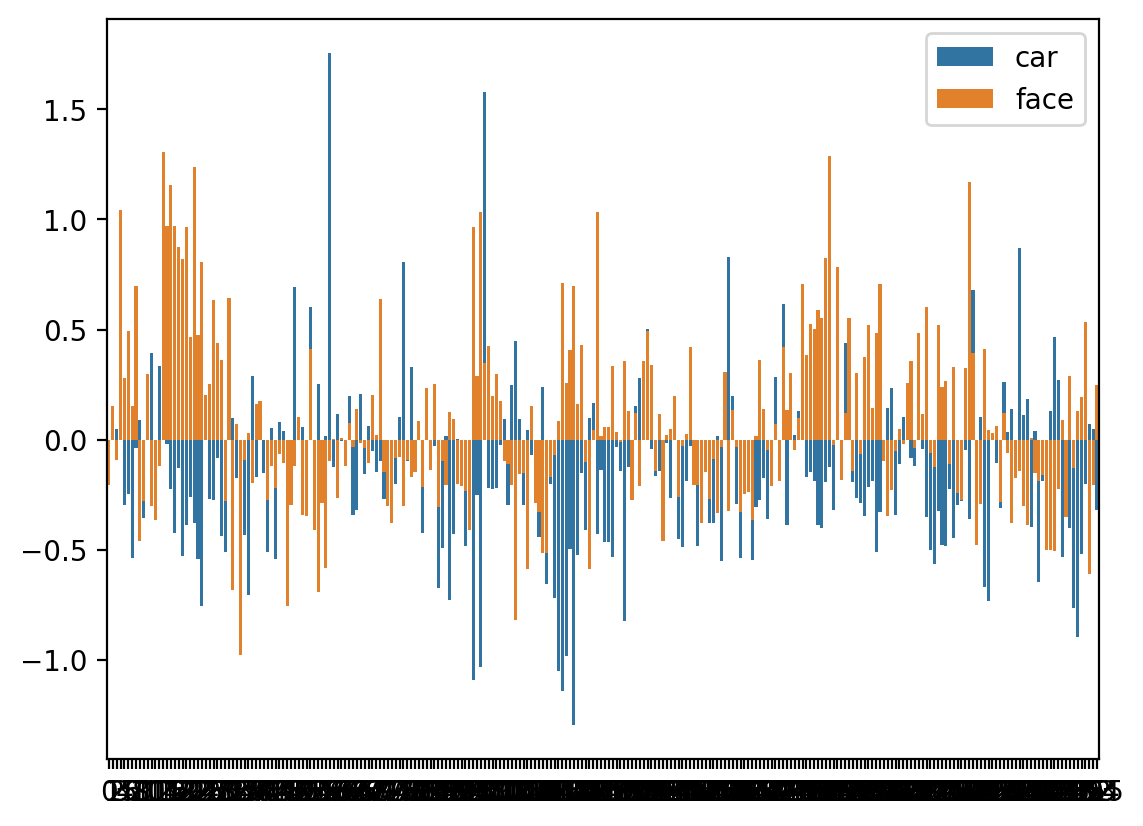

In [23]:
xs = np.array(range(len(stim1_data)))
ax = sns.barplot(x=xs, y=stim1_data, label="car")
ax = sns.barplot(x=xs, y=stim2_data, label="face", ax=ax)

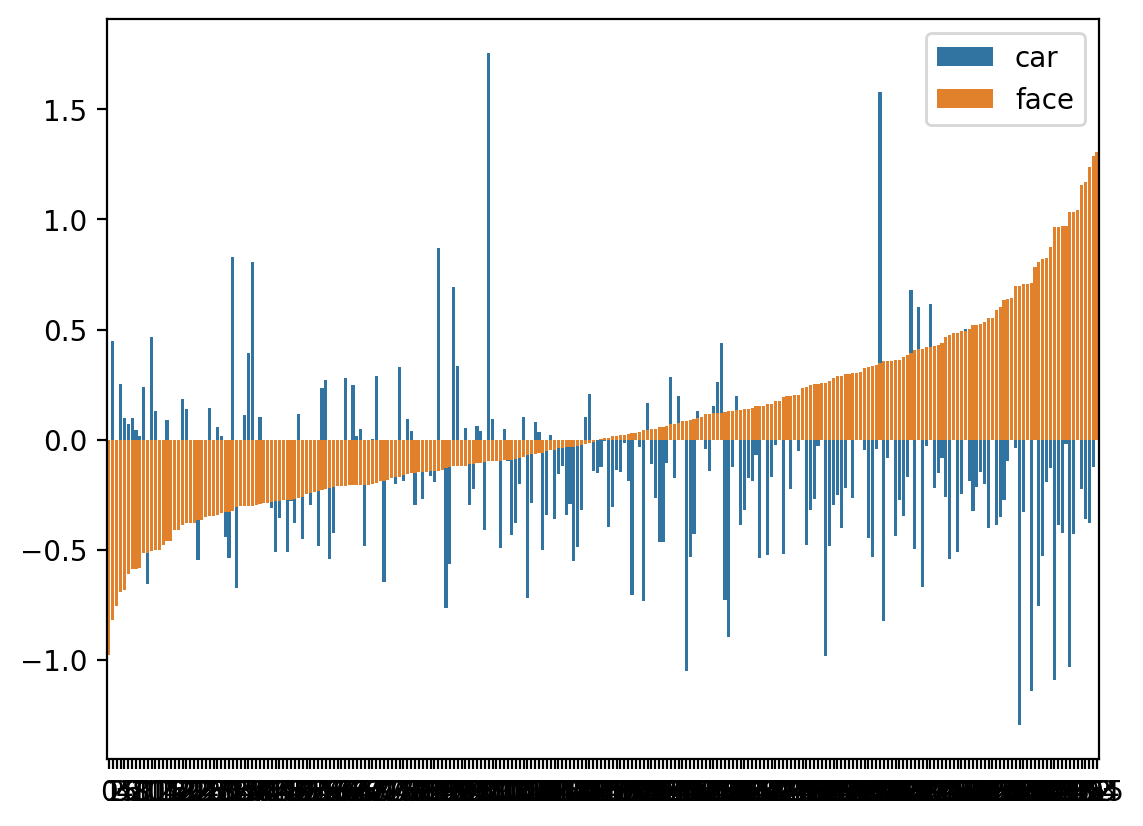

In [25]:
# let's sort by response to face
sort_indices = np.argsort(stim2_data)
xs = np.array(range(len(stim1_data)))
ax = sns.barplot(x=xs, y=stim1_data[sort_indices], label="car")
ax = sns.barplot(x=xs, y=stim2_data[sort_indices], label="face", ax=ax)

## Would the responses be more similar for two faces?

In [26]:
faces = np.where(stimulus_set.category_name == "Faces")[0]
faces

array([   2,    8,   24,   29,   43,   44,   66,   68,   76,   81,   91,
        100,  102,  116,  120,  124,  129,  132,  134,  138,  145,  149,
        150,  159,  163,  164,  175,  186,  196,  205,  214,  216,  225,
        226,  228,  229,  244,  250,  266,  268,  270,  273,  274,  286,
        294,  315,  330,  338,  354,  355,  359,  363,  367,  376,  386,
        390,  417,  444,  446,  457,  459,  460,  464,  468,  474,  485,
        491,  498,  535,  556,  558,  559,  564,  567,  568,  574,  581,
        591,  597,  626,  652,  659,  664,  698,  723,  743,  752,  756,
        766,  782,  787,  803,  805,  807,  813,  825,  837,  838,  848,
        855,  868,  884,  890,  892,  913,  916,  918,  919,  922,  925,
        929,  937,  938,  950,  955,  966,  971,  975,  976,  978,  982,
        987, 1003, 1014, 1017, 1021, 1074, 1087, 1089, 1103, 1104, 1119,
       1137, 1152, 1153, 1160, 1164, 1167, 1180, 1195, 1200, 1201, 1204,
       1206, 1215, 1216, 1229, 1246, 1250, 1253, 12

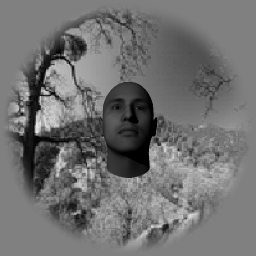

In [27]:
img1_info = stimulus_set.iloc[faces[0]]
local_path = stimulus_set.get_stimulus(img1_info.stimulus_id)
img1 = Image.open(local_path)
img1

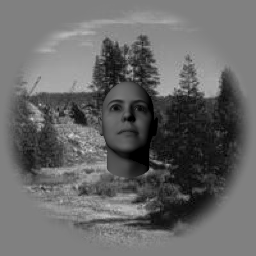

In [28]:
img2_info = stimulus_set.iloc[faces[20]] # same guy, different background
img2_info = stimulus_set.iloc[faces[2]] # diff guy, diff background
local_path = stimulus_set.get_stimulus(img2_info.stimulus_id)
img2 = Image.open(local_path)
img2

In [35]:
# access all the data for each image
neural_data_for_stimulus1 = assembly.sel(presentation=assembly['stimulus_id'] == img1_info.stimulus_id)
neural_data_for_stimulus2 = assembly.sel(presentation=assembly['stimulus_id'] == img2_info.stimulus_id)

# average across presentations
stim1_data = neural_data_for_stimulus1.data.mean(axis=1).compute().flatten()
stim2_data = neural_data_for_stimulus2.data.mean(axis=1).compute().flatten()

# correlation
pearsonr(stim1_data, stim2_data)

PearsonRResult(statistic=0.7582299404571131, pvalue=0.0)

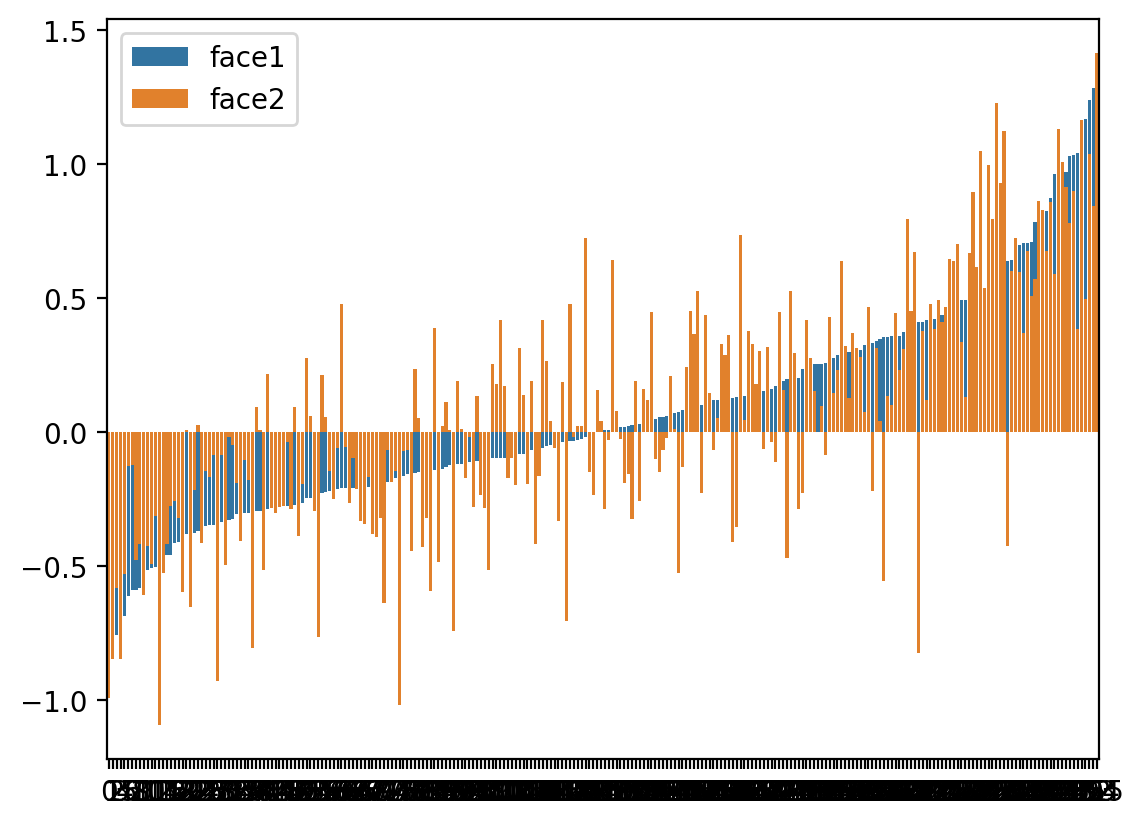

In [36]:
# plot sorted by face1
sort_indices = np.argsort(stim1_data)
xs = np.array(range(len(stim1_data)))
ax = sns.barplot(x=xs, y=stim1_data[sort_indices], label="face1")
ax = sns.barplot(x=xs, y=stim2_data[sort_indices], label="face2", ax=ax)

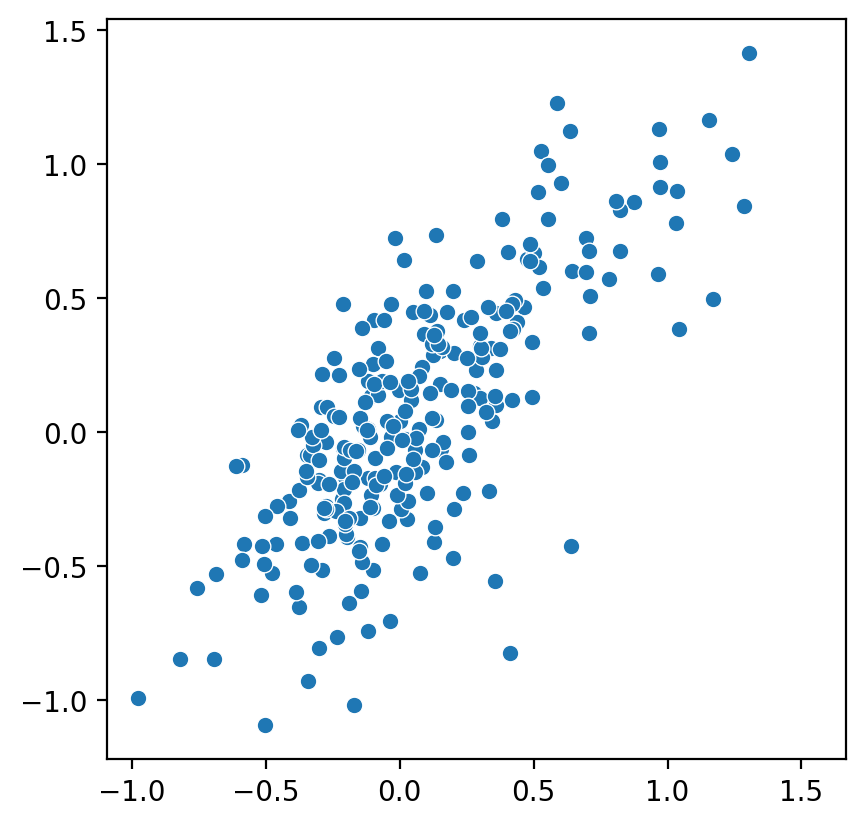

In [42]:
ax = sns.scatterplot(x=stim1_data, y=stim2_data)
ax.axis('square');

**are responses "even more similar" for the same face presented twice?**

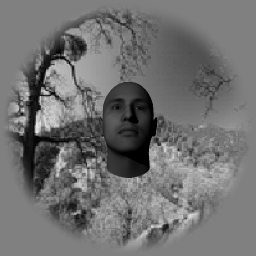

In [43]:
img1_info = stimulus_set.iloc[faces[0]]
local_path = stimulus_set.get_stimulus(img1_info.stimulus_id)
img1 = Image.open(local_path)
img1

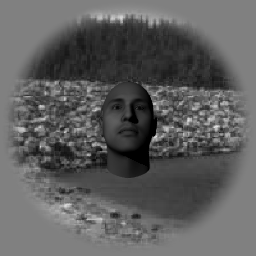

In [44]:
img2_info = stimulus_set.iloc[faces[20]] # same guy, different background
local_path = stimulus_set.get_stimulus(img2_info.stimulus_id)
img2 = Image.open(local_path)
img2

In [45]:
# access all the data for each image
neural_data_for_stimulus1 = assembly.sel(presentation=assembly['stimulus_id'] == img1_info.stimulus_id)
neural_data_for_stimulus2 = assembly.sel(presentation=assembly['stimulus_id'] == img2_info.stimulus_id)

# average across presentations
stim1_data = neural_data_for_stimulus1.data.mean(axis=1).compute().flatten()
stim2_data = neural_data_for_stimulus2.data.mean(axis=1).compute().flatten()

# correlation
pearsonr(stim1_data, stim2_data)

PearsonRResult(statistic=0.7582299404571131, pvalue=0.0)

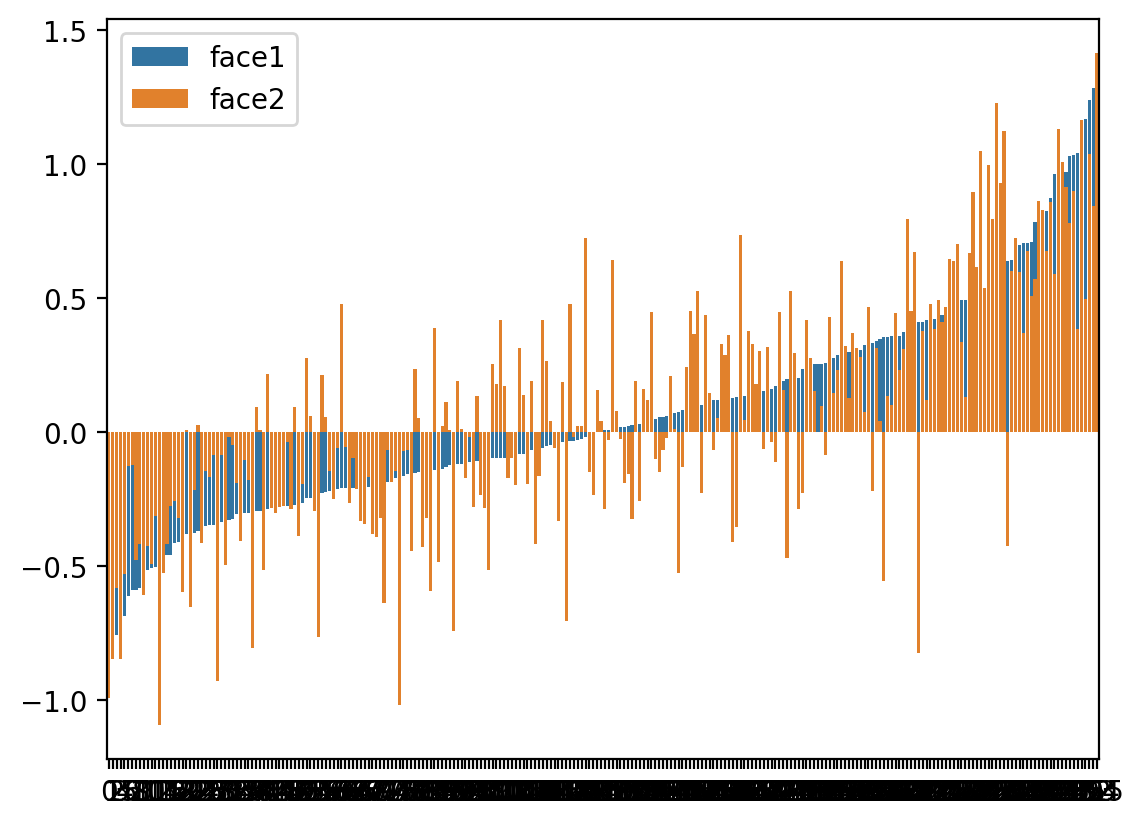

In [46]:
# plot sorted by face1
sort_indices = np.argsort(stim1_data)
xs = np.array(range(len(stim1_data)))
ax = sns.barplot(x=xs, y=stim1_data[sort_indices], label="face1")
ax = sns.barplot(x=xs, y=stim2_data[sort_indices], label="face2", ax=ax)

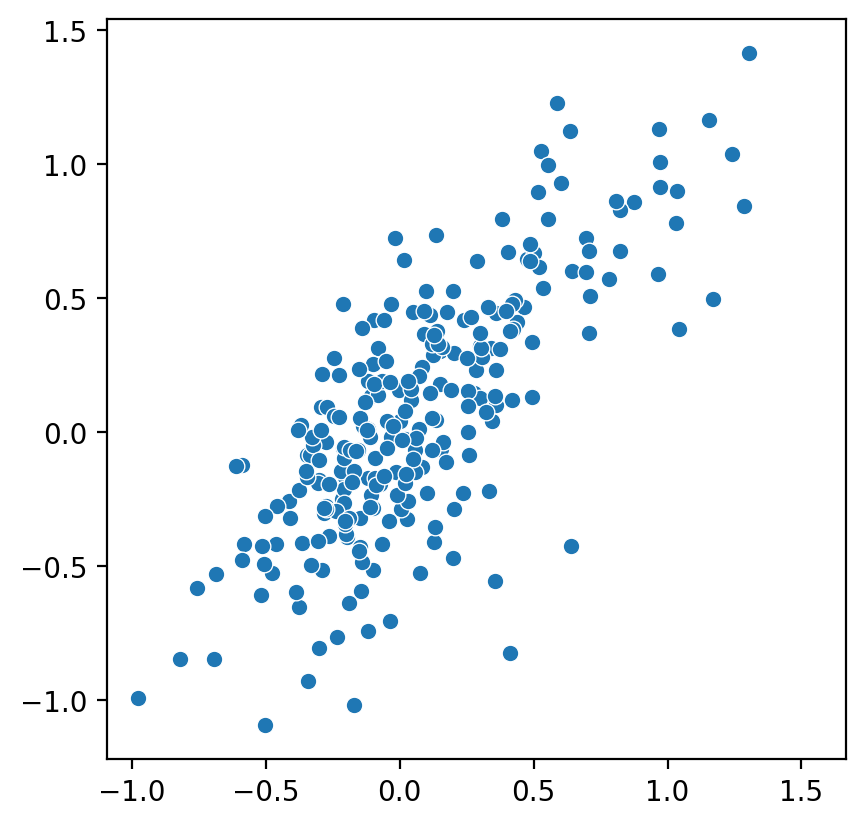

In [47]:
ax = sns.scatterplot(x=stim1_data, y=stim2_data)
ax.axis('square');

# 4. compute noise ceiing

OK, let's take stock of where we are. We understand a lot more about this brain dataset now. We've seen that there are 256 neural sites (across two monkeys) with measured neural responses to 148480 image presentations. We've seen some of the images that were shown, and how responses varied across those neural sites. We also saw that more-similar images elicit more similar "patterns" across these neural sites.

But how sure are we of exactly what the pattern of responses for these images for each of these sites? If we "ran the experiment again" would we see the same magnitude of response for each item in each site?

Fortunately they presented each image multiple times (at least 28 times, typically about 50), so instead of "running the experiment again" we can split the data in half, and compare scores between the first and second half. 

This is called computing the "split half reliability" of your data. Here's the general recipe:
- choose a single neural site, and select its data
- randomly split the data into two halves by presentation, so half1 gets some random set of presentations (e.g., presentation 1,2,5,7,9) and the other half gets the other presentations (e.g., 3,4,6,8,10). 
- Then responses across presentation, separately for each half of the data, which gives us the average response for each image separately for each half of the data.
- we then correlate those responses across items, and see if the scores are very similar for the first and second split of the data.
- Note that we have estimated how reliable "half of our data" is, but we wan't to know how reliable the full dataset is! Fortunatley, someone figured out the math for how to adjust split-half reliability scores to estimate the reliability of the full dataset. So we finish by applying this standard "correction" which finally give us our estimated reliability. This final number represents "how correlated we expect data would be if we actually did run the entire experiment again, and correlated these scores with the new scores". No model could be expected to predict the data more accurately than an exact replication of the experiment could.
- Finally, we repeat this procedure N times (brainscore uses 10 repetitions) and average the estimate over those repetitions, just to make sure that your estimate doesn't depend on the particular "random split" of the trials.


## compute noise ceiling with brainscore functions

Here we'll use the built-in brainscore function, which will give a noise ceiling of 0.81579938.

In [10]:
import numpy as np
import pandas as pd

from brainio.assemblies import walk_coords, DataAssembly

from brainscore_vision import benchmark_registry
from brainscore_vision import load_metric, Ceiling, load_ceiling, load_dataset
from brainscore_vision.metrics.distribution_similarity import NeuronalPropertyCeiling
from brainscore_core.metrics import Metric, Score
from brainscore_vision.metric_helpers import Defaults as XarrayDefaults

from brainscore_vision.benchmarks.majajhong2015 import *
from brainscore_vision import benchmark_registry

**note that we are using "load_assembly" to load the dataset**

I noticed that this is what brainscore does under the hood, and it looks like they do some pre-processing that removes some neural sites, and also transposes the data array (presentation is rows, neuroid is columns).

In [11]:
from brainscore_vision.benchmarks.majajhong2015.benchmark import load_assembly

region = "IT"
access = "public"
time_interval = None
assembly_repetition = load_assembly(average_repetitions=False, 
                                    region=region, 
                                    access=access, 
                                    time_interval=time_interval)
print(assembly_repetition.shape)
assembly_repetition

(148480, 168)


<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (
                                                                presentation: 148480,
                                                                neuroid: 168)>
array([[ 0.06092933, -0.72559214,  0.42031842, ..., -0.18637353,
         0.28050217,  0.30726328],
       [-0.8479065 ,  0.89549875,  0.9519652 , ..., -2.260826  ,
        -1.1872205 ,  0.35321778],
       [-1.618728  , -0.7792393 , -1.3977592 , ...,  0.22751288,
        -0.17249185,  0.10181567],
       ...,
       [-0.83211136, -1.5217171 ,  1.1938343 , ...,  0.6354223 ,
         0.42337415, -2.2552547 ],
       [-0.83211136, -1.158598  , -0.17778037, ..., -1.6090839 ,
         0.0775381 ,  1.0052351 ],
       [-0.83211136, -0.7954789 , -0.8635877 , ...,  0.6354223 ,
        -0.614134  , -0.2989609 ]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 18 18 18 18 18 ... 16 16 16 17 17 17
  - stimulus         (presentation) int64 0 426 427 428 429 ... 2569 2566 0 1 2
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 418 419 420 421 ... 3197 641 642 643
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 ... 1.246 1.296 0.9114
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... 0.02724 -10.4
  - tz               (presentation) float64 0.0 0.0 0.0 ... -0.269 -0.599 0.211
  - category_name    (presentation) object 'Cars' 'Faces' ... 'Fruits' 'Fruits'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  - ty               (presentation) float64 0.0 0.0 0.0 ... -0.191 -0.213 0.277
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - object_name      (presentation) object 'car_astra' 'face0' ... 'apple'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 -0.0 -0.0 ... 0.02724 -10.4
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - rxz              (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
    time_bin         object (70, 170)
    region           (neuroid) <U2 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [12]:
# the "internal_consistency" class performs 10 iterations of Split-half reliability with the spearman brown correction
ceiler = load_ceiling('internal_consistency')
ceiler

Defaulting to user installation because normal site-packages is not writeable


In [13]:
# ceiling should be: array(0.81579938)
ceiling = ceiler(assembly_repetition)
ceiling

cross-validation: 100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


<xarray.DataArray ()>
array(0.81579938)
Attributes:
    raw:      <xarray.DataArray (split: 10, neuroid: 168)>\narray([[0.1951266...
    error:    <xarray.DataArray ()>\narray(0.00144955)

In [14]:
# notice we have 10 scores, with a separate score for each of the 168 neuroids
# the 10 scores correspond to the splilts of the data into halves
ceiling.raw.shape

(10, 168)

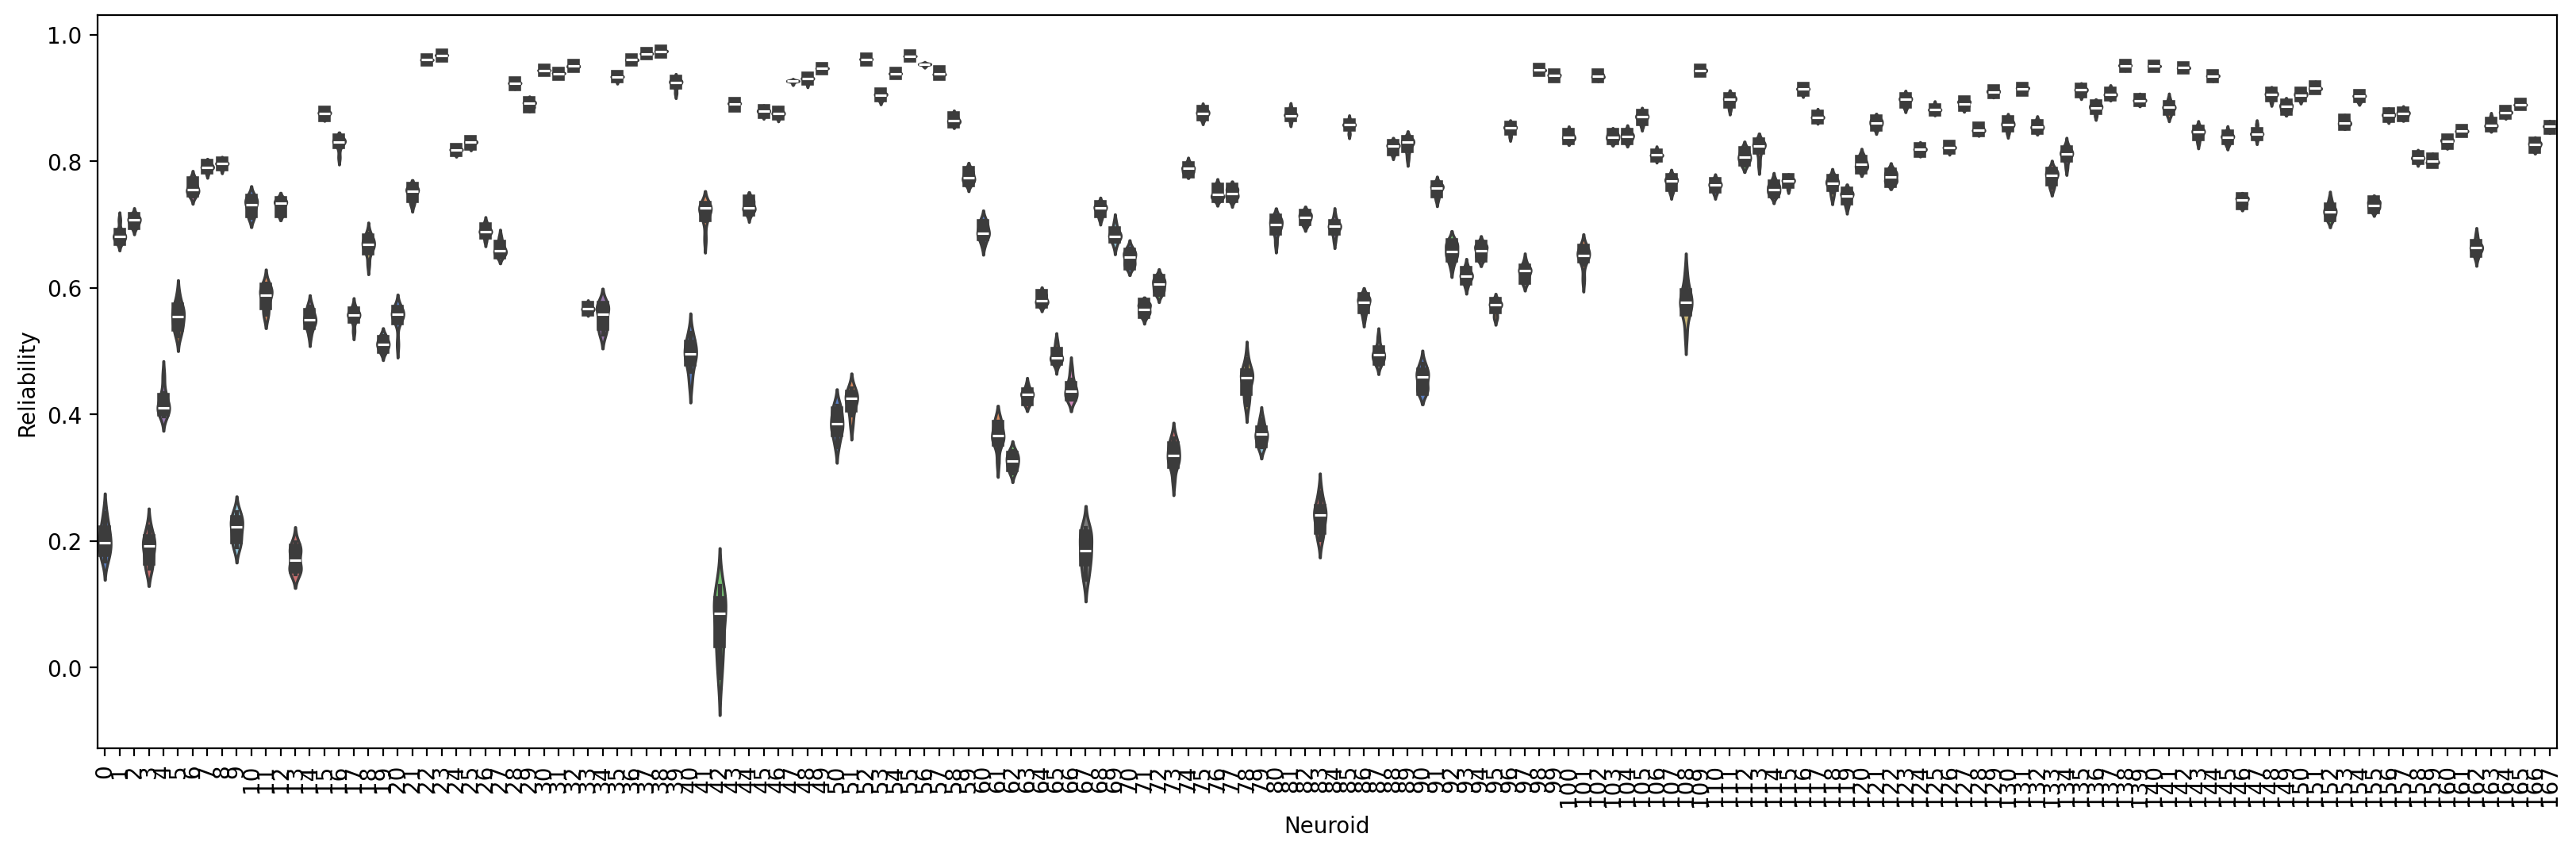

In [15]:
# Convert to a DataFrame with long format
df = pd.DataFrame(ceiling.raw)
df = df.melt(var_name="Neuroid", value_name="Reliability")

# Create a violin plot for each neuroid
plt.figure(figsize=(20, 6))  # Adjust size for readability
sns.violinplot(x="Neuroid", y="Reliability", data=df, palette="muted", inner="box", 
               hue="Neuroid", legend=False)
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

## compute noise ceiling step-by-step

Here we're going to unpack the "ceiler" function a little, and see how it works step-by-step.

Why bother? The goal is to make sure we really understand how things are being computed.

Note also that the brainscore code uses a horrendously difficult to navigate maze of classes, each with superpowers that transform, aggregate, and process the data in difficut-to-track ways. So a secondary goal is to re-write this analysis with a set of declarative functions where someone can actually read and understand what's happening.

Ideally we'd have a function that we'd call like this:
```
ceiling = compute_split_half_ceiling(data, num_splits=10)
```

And the resulting "ceiling" scores would be 10 splits x 168 numNeuroIds. But as we'll see, it's not that simple, because you have to be careful to organize the data correctly at each step...so let's see how this goes:

- step1 load the neural data
- step2 get the indices for randomly splitting the data into two halves
- step3 iterate over splits
- for each split, get the response to each unique image averaged over repetitions for half1 and half2
- compute the correlation between half1 and half2
- compute the corrected ceiling
- store the scores

In [16]:
from tqdm import tqdm
from brainio.transform import subset
from brainscore_vision.benchmark_helpers.neural_common import average_repetition
from brainscore_vision.metrics import Score
from scipy.stats import pearsonr

import xarray as xr
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit, ShuffleSplit

def split_data(assembly, 
               splits=10, train_size=None, test_size=None,
               split_coord='stimulus_id', stratification_coord='object_name', 
               kfold=False, unique_split_values=False, random_state=1, 
               preprocess_indices=None):

    # Determine train and test sizes (size of splits)
    if train_size is None and test_size is None:
        train_size = 0.9

    # Choose the split strategy
    if kfold:
        assert (train_size is None or train_size == 0.9) and test_size is None
        if stratification_coord:
            splitter = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)
        else:
            splitter = KFold(n_splits=splits, shuffle=True, random_state=random_state)
    else:
        if stratification_coord:
            splitter = StratifiedShuffleSplit(n_splits=splits, train_size=train_size, test_size=test_size, random_state=random_state)
        else:
            splitter = ShuffleSplit(n_splits=splits, train_size=train_size, test_size=test_size, random_state=random_state)

    # Extract relevant data
    cross_validation_values, indices = extract_coord(assembly, split_coord, unique=unique_split_values)
    data_shape = np.zeros(len(cross_validation_values))
    args = [assembly[stratification_coord].values[indices]] if stratification_coord else []
    
    # Generate splits
    splits = list(splitter.split(data_shape, *args))
    return cross_validation_values, splits

def extract_coord(assembly, coord, unique=False):
    if not unique:
        coord_values = assembly[coord].values
        indices = list(range(len(coord_values)))
    else:
        # need unique values for when e.g. repetitions are heavily redundant and splits would yield equal unique values
        coord_values, indices = np.unique(assembly[coord].values, return_index=True)
    dims = assembly[coord].dims
    assert len(dims) == 1
    extracted_assembly = xr.DataArray(coord_values, coords={coord: coord_values}, dims=[coord])
    extracted_assembly = extracted_assembly.stack(**{dims[0]: (coord,)})
    return extracted_assembly if not unique else extracted_assembly, indices

def _average_repetitions(assembly, split_coord):
    repetition_dims = assembly[split_coord].dims
    nonrepetition_coords = [coord for coord, dims, values in walk_coords(assembly)
                            if dims == repetition_dims and coord != split_coord]
    average = assembly.multi_groupby(nonrepetition_coords).mean(dim=repetition_dims)
    return average  

**STEP1: Load the neural_data**

In [17]:
from brainscore_vision.benchmarks.majajhong2015.benchmark import load_assembly

region = "IT"
access = "public"
time_interval = None
assembly_repetition = load_assembly(average_repetitions=False, 
                                    region=region, 
                                    access=access, 
                                    time_interval=time_interval)
print(assembly_repetition.shape)
assembly_repetition

(148480, 168)


<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (
                                                                presentation: 148480,
                                                                neuroid: 168)>
array([[ 0.06092933, -0.72559214,  0.42031842, ..., -0.18637353,
         0.28050217,  0.30726328],
       [-0.8479065 ,  0.89549875,  0.9519652 , ..., -2.260826  ,
        -1.1872205 ,  0.35321778],
       [-1.618728  , -0.7792393 , -1.3977592 , ...,  0.22751288,
        -0.17249185,  0.10181567],
       ...,
       [-0.83211136, -1.5217171 ,  1.1938343 , ...,  0.6354223 ,
         0.42337415, -2.2552547 ],
       [-0.83211136, -1.158598  , -0.17778037, ..., -1.6090839 ,
         0.0775381 ,  1.0052351 ],
       [-0.83211136, -0.7954789 , -0.8635877 , ...,  0.6354223 ,
        -0.614134  , -0.2989609 ]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 18 18 18 18 18 ... 16 16 16 17 17 17
  - stimulus         (presentation) int64 0 426 427 428 429 ... 2569 2566 0 1 2
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 418 419 420 421 ... 3197 641 642 643
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 ... 1.246 1.296 0.9114
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... 0.02724 -10.4
  - tz               (presentation) float64 0.0 0.0 0.0 ... -0.269 -0.599 0.211
  - category_name    (presentation) object 'Cars' 'Faces' ... 'Fruits' 'Fruits'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  - ty               (presentation) float64 0.0 0.0 0.0 ... -0.191 -0.213 0.277
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - object_name      (presentation) object 'car_astra' 'face0' ... 'apple'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 -0.0 -0.0 ... 0.02724 -10.4
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - rxz              (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
    time_bin         object (70, 170)
    region           (neuroid) <U2 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

**STEP 2: setup the splits**

In [18]:

# cross_validation_values indicate the "repetition number" for each of the 148480 trials
# splits are 10 tupules with indices for split1, split2 (i.e., non-overlapping lists of indices indicating 
# which repetitions to include in split1 vs. split2)
cross_validation_values, splits = split_data(assembly_repetition, 
                                             splits=10, 
                                             train_size=.5, # split data into two equal halves
                                             split_coord='repetition', # splitting on repetition coordinate
                                             stratification_coord=None,  # not stratifying the splitting
                                             unique_split_values=True, 
                                             random_state=1)

In [130]:
cross_validation_values

<xarray.DataArray (presentation: 51)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])
Coordinates:
  * presentation  (presentation) MultiIndex
  - repetition    (presentation) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50

In [135]:
split1_indices, split2_indices = splits[0]
print("split1", split1_indices)
print("split2", split2_indices)

split1 [ 4 34 14 31 10 28 45 35 18 20 25  6  7 48  1 16  0 15  5 11  9  8 12 43
 37]
split2 [22  2 49 26 33 44 30 50 32 27  3 29 47 41 39 21 40 38 19 24 13 42 17 46
 36 23]


**Using Brainscores Correlation and Correction functions**

In [19]:
import scipy 
from brainscore_vision.metric_helpers.xarray_utils import XarrayCorrelation
from brainscore_vision.metrics.internal_consistency.ceiling import Score, SpearmanBrownCorrection

_correlation = XarrayCorrelation(scipy.stats.pearsonr, 
                                 correlation_coord='stimulus_id', # correlating over stimulus_id
                                 neuroid_coord='neuroid_id') # separate correlation for each neuroid_coord

correction = SpearmanBrownCorrection()

**step3: iterate over splits, computing scores**

In [21]:
split_coord = 'repetition'
assembly = assembly_repetition
split_scores = []
for split_num, (split1_indices, split2_indices) \
        in tqdm(enumerate(splits), total=len(splits), desc='split-half reliability'):
    split1_values, split2_values = cross_validation_values[split1_indices], cross_validation_values[split2_indices]
    
    # get the subsets of data for split1 and split2
    split1_data = subset(assembly, split1_values, dims_must_match=False)
    split2_data = subset(assembly, split2_values, dims_must_match=False)
    
    # Average of repetitions, computing separate average for each stimulus and neural site:
    # _average_repetitions is helpfu because it groups the data by all of the coordinates 
    # other than 'repetition', so for our purposes, this is going to compute a separate average
    # for each unique image (3200) in each neural site (168)
    half1 = _average_repetitions(split1_data, split_coord)
    half2 = _average_repetitions(split2_data, split_coord)
    
    # next, we're computing the correlation between each half
    # we're using brainscores XarrayCorrelation because it nicely asserts that half1, half2 are 
    # aligned (stimuli in the same order), and quickly iterates over neuroid sites
    consistency = _correlation(half1, half2)
    
    # next, we compute the corrected score using the spearman brown correction
    corrected_consistency = correction(consistency, n=2)
    
    # at the split_num to the score xarray metadata
    split_score = corrected_consistency.expand_dims('split')
    split_score['split'] = [split_num]
    split_scores.append(split_score)

# Finally, merge all of the xarrays into one final xarray structure    
split_scores = Score.merge(*split_scores)
split_scores

split-half reliability: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


<xarray.DataArray (split: 10, neuroid: 168)>
array([[0.1951266 , 0.6710363 , 0.70019036, ..., 0.8906245 , 0.82681467,
        0.8486802 ],
       [0.22636659, 0.68390091, 0.71682185, ..., 0.88856218, 0.82896516,
        0.85490966],
       [0.21533617, 0.70659452, 0.70566915, ..., 0.88953989, 0.82539537,
        0.85097236],
       ...,
       [0.18118524, 0.68670523, 0.69847358, ..., 0.89357499, 0.82146316,
        0.85952356],
       [0.24512851, 0.67569792, 0.69308269, ..., 0.89219362, 0.81786032,
        0.85555973],
       [0.19640871, 0.6832725 , 0.70856556, ..., 0.88817281, 0.82258442,
        0.84959486]])
Coordinates:
  * split       (split) int64 0 1 2 3 4 5 6 7 8 9
  * neuroid     (neuroid) MultiIndex
  - neuroid_id  (neuroid) object 'Chabo_L_A_2_4' ... 'Tito_L_M_9_8'
  - arr         (neuroid) object 'A' 'A' 'A' 'A' 'A' 'A' ... 'M' 'M' 'M' 'M' 'M'
  - col         (neuroid) int64 4 3 5 0 1 2 3 4 5 6 2 ... 4 5 6 7 8 1 3 4 5 7 8
  - hemisphere  (neuroid) object 'L' 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion   (neuroid) object 'cIT' 'cIT' 'aIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal      (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y           (neuroid) float64 -1.0 -0.6 -0.6 -0.2 -0.2 ... 1.8 1.8 1.8 1.8
  - x           (neuroid) float64 -0.2 -0.6 0.2 -1.8 -1.4 ... -0.2 0.2 1.0 1.4
  - row         (neuroid) int64 2 3 3 4 4 4 4 4 4 4 5 ... 8 8 8 8 8 9 9 9 9 9 9
  - region      (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'

**alas, check whether all of these scores are close to the brainscore ceiling scores**


In [22]:
np.allclose(ceiling.raw, split_scores.data)

True

In [23]:
# The final score computed by brain score is the median across neural sites, the averaged across splits
noise_ceiling = np.nanmedian(split_scores.data, axis=1).mean()
noise_ceiling

0.8157993788025764

In [24]:
ceiling

<xarray.DataArray ()>
array(0.81579938)
Attributes:
    raw:      <xarray.DataArray (split: 10, neuroid: 168)>\narray([[0.1951266...
    error:    <xarray.DataArray ()>\narray(0.00144955)

## DIY

We could go one level deeper and use even less "helper code" from brainscore.

In [35]:
from tqdm import tqdm

# def response_per_stimulus_id(data, stimulus_ids):
#     # Get the unique stimulus IDs and their corresponding indices
#     unique_stims, stim_inverse_indices = np.unique(stimulus_ids, return_inverse=True)
    
#     # Initialize an array to store the sum of data for each stimulus
#     stim_data_sum = np.zeros((len(unique_stims), data.shape[1]))
#     stim_data_count = np.zeros(len(unique_stims))
    
#     # Accumulate the sum of the data and the count for each stimulus
#     np.add.at(stim_data_sum, stim_inverse_indices, data)
#     np.add.at(stim_data_count, stim_inverse_indices, 1)
    
#     # Compute the average by dividing the sum by the count
#     stim_avg_data = stim_data_sum / stim_data_count[:, None]

#     return stim_avg_data, unique_stims

# def response_per_stimulus_id(data, stimulus_ids):
#     # Convert xarray DataArray to numpy arrays
#     if hasattr(data, 'values'):
#         data = data.values
#     if hasattr(stimulus_ids, 'values'):
#         stimulus_ids = stimulus_ids.values
    
#     # Get the unique stimulus IDs and the index of their first occurrence (to preserve order)
#     unique_stims, stim_inverse_indices = np.unique(stimulus_ids, return_inverse=True)
    
#     # Initialize an array to store the sum of data for each stimulus
#     stim_data_sum = np.zeros((len(unique_stims), data.shape[1]))
#     stim_data_count = np.zeros(len(unique_stims))
    
#     # Accumulate the sum of the data and the count for each stimulus
#     np.add.at(stim_data_sum, stim_inverse_indices, data)
#     np.add.at(stim_data_count, stim_inverse_indices, 1)
    
#     # Compute the average by dividing the sum by the count
#     stim_avg_data = stim_data_sum / stim_data_count[:, None]

#     return stim_avg_data, unique_stims

def response_per_stimulus_id(data, stimulus_ids):
    # Convert xarray DataArray to numpy arrays, if needed
    if hasattr(data, 'values'):
        data = data.values
    if hasattr(stimulus_ids, 'values'):
        stimulus_ids = stimulus_ids.values

    # Get unique stimulus IDs and their corresponding inverse indices
    unique_stims, stim_inverse_indices = np.unique(stimulus_ids, return_inverse=True)

    # Initialize an array to store the averaged data (rows: stimuli, columns: neural responses)
    stim_avg_data = np.zeros((len(unique_stims), data.shape[1]))

    # Iterate over each column and compute the averages per stimulus
    for col in range(data.shape[1]):
        # Sum and count the data for each stimulus using np.bincount
        stim_sums = np.bincount(stim_inverse_indices, weights=data[:, col])
        stim_counts = np.bincount(stim_inverse_indices)
        
        # Compute the average for each stimulus
        stim_avg_data[:, col] = stim_sums / stim_counts

    return stim_avg_data, unique_stims

In [36]:
assembly = assembly_repetition
split_scores = []
for split_num, (split1_indices, split2_indices) \
        in tqdm(enumerate(splits), total=len(splits), desc='split-half reliability'):
    split1_values, split2_values = cross_validation_values[split1_indices], cross_validation_values[split2_indices]
    
    # split1_data = subset(assembly, split1_values, dims_must_match=False)
    split1_mask = np.isin(assembly.repetition.values, split1_values)
    split1_data = assembly.values[split1_mask,:]
    split1_rep = assembly.repetition[split1_mask]
    split1_stim = assembly.stimulus_id[split1_mask]
    
    # split2_data = subset(assembly, split2_values, dims_must_match=False)
    split2_mask = np.isin(assembly.repetition.values, split2_values)
    split2_data = assembly.values[split2_mask,:]
    split2_rep = assembly.repetition[split2_mask]
    split2_stim = assembly.stimulus_id[split2_mask]
    
    # compute the averge over repetition separately for each stimulus and neuralid
    split1_avg, split1_ids = response_per_stimulus_id(split1_data, split1_stim)
    split2_avg, split2_ids = response_per_stimulus_id(split2_data, split2_stim)
    
    # make sure they have the same images in the same order
    assert (split1_ids==split2_ids).all(), "Oops, failed to align halves of the data"
    
    # compute correlations
    correlations = [pearsonr(split1_avg[:,i], split2_avg[:,i])[0] for i in range(split2_avg.shape[1])]
    
    # compute adjusted score
    corrected_consistency = [correction(consistency, n=2) for consistency in correlations]
    
    split_scores.append(corrected_consistency)
    
split_scores = np.array(split_scores)
split_scores

split-half reliability: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


array([[0.71469898, 0.87354568, 0.88686994, ..., 0.83385736, 0.66382621,
        0.72090955],
       [0.73766403, 0.87880037, 0.89301306, ..., 0.84436549, 0.65467727,
        0.72286909],
       [0.72382468, 0.87615659, 0.89132623, ..., 0.8411233 , 0.66215666,
        0.73189279],
       ...,
       [0.72557841, 0.8803298 , 0.8909216 , ..., 0.84159351, 0.68217004,
        0.73819699],
       [0.74005426, 0.87446416, 0.88550551, ..., 0.84290703, 0.66066151,
        0.73702087],
       [0.72770342, 0.87133615, 0.88527529, ..., 0.84223107, 0.64646836,
        0.72799897]])

In [37]:
# these scores don't perfectly align with the original because the sorting of rows/cols is different
np.allclose(ceiling.raw.values, split_scores.data)

False

In [38]:
# but if we sort all of the values they line up
np.allclose(np.sort(ceiling.raw.values.flatten()), np.sort(split_scores.flatten()))

True

In [40]:
# The final score computed by brain score is the median across neural sites, the averaged across splits
noise_ceiling = np.nanmedian(split_scores.data, axis=1).mean()
noise_ceiling

0.8157993793730771

In [39]:
ceiling

<xarray.DataArray ()>
array(0.81579938)
Attributes:
    raw:      <xarray.DataArray (split: 10, neuroid: 168)>\narray([[0.1951266...
    error:    <xarray.DataArray ()>\narray(0.00144955)